In [ ]:
import os
from shutil import copy
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

extract_to_360_path = '/content/drive/My Drive/360 Rocks'
extract_to_120_path = '/content/drive/My Drive/120 Rocks'


Mounted at /content/drive


**1. From the '360 rocks' folder create a training dataset that has 30 categories and 12 images in each category. To create the categories, group the rocks by name: e.g., one category will be 12 Andesite rocks, another category will be 12 Basalt rocks, etc.  From  '120 rocks' folder create a validation dataset that has 30 categories and 4 images in each category.**

In [ ]:
import shutil
import os

def create_datasets(source_folder, dest_folder, num_categories, num_images_per_category, numItemsToExclude):
    categories = defaultdict(list)
    for filename in os.listdir(source_folder):
        if filename.endswith('.jpg'):
            category_name = '_'.join(filename.split('_')[:-numItemsToExclude])
            categories[category_name].append(filename)
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for category, files in categories.items():
        if len(files) >= num_images_per_category:
            category_folder = os.path.join(dest_folder, category)
            os.makedirs(category_folder, exist_ok=True)
            for file in files[:num_images_per_category]:
                source_path = os.path.join(source_folder, file)
                dest_path = os.path.join(category_folder, file)
                copy(source_path, dest_path)

train_folder = '/content/drive/My Drive/training_dataset'
val_folder = '/content/drive/My Drive/validation_dataset'

if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

if os.path.exists(val_folder):
    shutil.rmtree(val_folder)


create_datasets(extract_to_360_path, train_folder, 30, 12, 1)
create_datasets(extract_to_120_path, val_folder, 30, 4, 2)

**2. Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

train_dir = '/content/drive/My Drive/training_dataset'
val_dir = '/content/drive/My Drive/validation_dataset'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)


Found 360 images belonging to 30 classes.
Found 120 images belonging to 30 classes.


**3. Fine-tune a pretrained neural network of your choice on the training data from the previous step. Before fine-tuning, you should remove the top layer of the pretrained network and add at least two more layers with a softmax activation function (your output layer should have 30 neurons and the layer before the output layer should have 8 neurons). For fine-tuning, you should first train for a few epochs only weights in the layers, and after that, you should train all the weights (you should try to run your code until convergence, but for at least 20 epochs). Display train and validation loss and accuracy during the training and make a plot showing train and validation loss and accuracy as a function of the training epoch (mark the epoch where you switched to training the whole network with a vertical line).**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import json

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(30, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

for layer in base_model.layers:
    layer.trainable = True

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 245
total_epochs = 5 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping]
)

model_save_path = '/content/drive/My Drive/my_model.h5'
model.save(model_save_path)

history_save_path = '/content/drive/My Drive/my_history.json'
with open(history_save_path, 'w') as f:
    json.dump(history.history, f)

Epoch 1/5
22/22 [==============================] - 15s 391ms/step - loss: 3.5267 - accuracy: 0.0465 - val_loss: 3.4114 - val_accuracy: 0.0179
Epoch 2/5
22/22 [==============================] - 13s 601ms/step - loss: 3.4765 - accuracy: 0.0465 - val_loss: 3.4063 - val_accuracy: 0.0268
Epoch 3/5
22/22 [==============================] - 9s 409ms/step - loss: 3.4954 - accuracy: 0.0465 - val_loss: 3.4108 - val_accuracy: 0.0357
Epoch 4/5
22/22 [==============================] - 9s 421ms/step - loss: 3.4516 - accuracy: 0.0552 - val_loss: 3.4287 - val_accuracy: 0.0446
Epoch 5/5
22/22 [==============================] - 10s 472ms/step - loss: 3.4421 - accuracy: 0.0640 - val_loss: 3.4378 - val_accuracy: 0.0357
Epoch 5/250
22/22 [==============================] - 48s 482ms/step - loss: 3.5209 - accuracy: 0.0291 - val_loss: 3.4367 - val_accuracy: 0.0446
Epoch 6/250
22/22 [==============================] - 10s 423ms/step - loss: 3.5607 - accuracy: 0.0291 - val_loss: 3.4751 - val_accuracy: 0.0357
Epoc

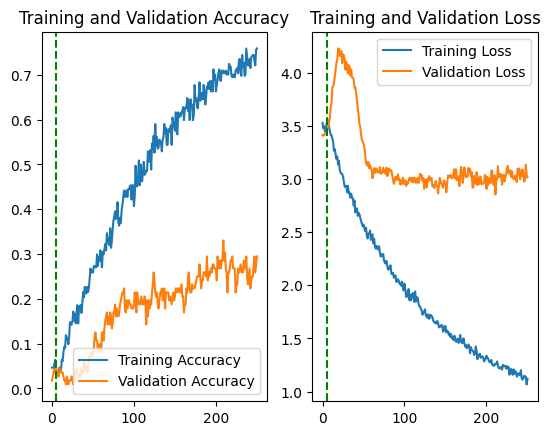

In [ ]:

# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(total_epochs+1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='green', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['accuracy']), color='green', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Based on the above training and graphs, which depicts the training and validation accuracy and its losses, over epochs, here is the discussion:

**1. Performance of the network:** The training accuracy shows a steady upward trend, signaling consistent improvement of the network's performance on the training dataset. Conversely, the growth of the validation accuracy is more gradual and plateaus toward the later epochs. This suggests that the model may be overfitting to the training data and, consequently, is not performing as well on data it has not seen before.

**2. Convergence:** The training loss experiences a rapid decline before stabilizing, which indicates that the model is effectively learning and stabilizing with the training data. The validation loss initially drops but then begins to show variability, pointing to a more gradual and less stable convergence concerning the unseen data.

**3. Hyperparameters tweaks tried:**


* Initially, attempts to train a VGG16 model did not yield an increase in accuracy for either the training or validation datasets, suggesting that the model wasn't effectively learning from the data.
* Subsequently, the switch to a ResNet50 model resulted in an uptick in training accuracy, which was a positive development, though the validation accuracy remained stagnant.
* Various batch sizes, including 12, 16 and 32, were experimented with; it was observed that a batch size of 16 led to a steady improvement in the model's training accuracy.
* The implementation of a learning rate scheduler and ReduceLROnPlateau callbacks slowed down the training, and the accuracy gains relative to the number of epochs were marginal.

* The model's architecture was then adjusted to include dropout and batch normalization layers, and the dropout rate was fine-tuned. These adjustments significantly enhanced the network's training capacity, culminating in improved accuracy and reduced loss on the training dataset, alongside better accuracy and loss metrics on the validation set.

* To further refine the network's performance, there's the potential to add more Dense layers, incorporate additional dropout layers, adjust dropout rates, and prolong the training duration across more epochs. Such enhancements aim to harness the intricate architecture of ResNet50 and elevate the model's capabilities. This process will likely entail extensive training and meticulous hyperparameter optimization.

**4. Conclusion on training:** The presence of a bottleneck layer with only 8 neurons preceding the final output layer of 30 neurons could be restricting the model's learning capacity. This narrow layer may be limiting the flow of information, rendering the knowledge acquired by these 8 neurons insufficient for the demands of the subsequent 30-neuron layer, thereby resulting in sluggish learning and initial underperformance of the model. To enhance the model's learning, increasing the number of neurons in the bottleneck layer, extending the number of training epochs, and adding complexity to the model may be beneficial strategies to pursue.










4. Compute the correlation coefficients between the network data and human data for each of the 8 neurons in your next-to-last layer (similar to HW3, using procrustes analysis) for the images from the train set (360 images) and (separately) for the images from the validation set (120 images). Report each of the 8 correlation coefficients and your average correlation coefficients (please mark in the bold with large font so we can easily find it).

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def createNumpyArrayOfImages(dir):
  images = []
  for category in sorted(os.listdir(dir)):
      if not os.path.isdir(os.path.join(dir, category)):
          continue

      for img_file in sorted(os.listdir(os.path.join(dir, category))):
          img_path = os.path.join(dir, category, img_file)
          img = image.load_img(img_path, target_size=(224, 224))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis=0)
          img_array = img_array / 255.
          images.append(img_array)
  images = np.vstack(images)

  return images

train_dir = '/content/drive/My Drive/training_dataset'
val_dir = '/content/drive/My Drive/validation_dataset'


train_images = createNumpyArrayOfImages(train_dir)
val_images = createNumpyArrayOfImages(val_dir)


In [ ]:
model_extract = Model(inputs=model.input, outputs=model.layers[-2].output)
train_activations = model_extract.predict(train_images)
val_activations = model_extract.predict(val_images)

4/4 [==============================] - 2s 672ms/step


In [ ]:
with open('/content/drive/My Drive/mds_360.txt', 'r') as file:
    human_data_train = np.array([[float(num) for num in line.split()] for line in file])

with open('/content/drive/My Drive/mds_120.txt', 'r') as file:
    human_data_val = np.array([[float(num) for num in line.split()] for line in file])


In [ ]:
train_activations.shape

(360, 8)

In [ ]:
human_data_train.shape

(360, 8)

The train_activations and human_data_train are in the shape of (360, 8)
and for the val_activations and human_data_val are in the shape of (120, 8)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_activations_norm = scaler.fit_transform(train_activations)
human_data_train_norm = scaler.fit_transform(human_data_train)

val_activations_norm = scaler.transform(val_activations)
human_data_val_norm = scaler.transform(human_data_val)


In [ ]:
from scipy.spatial import procrustes

train_mtx1, train_mtx2, disparity_train = procrustes(human_data_train_norm, train_activations_norm)
val_mtx1, val_mtx2, disparity_val = procrustes(human_data_val_norm, val_activations_norm)


In [ ]:
from scipy.stats import pearsonr

train_correlations = [pearsonr(train_mtx1[:,i], train_mtx2[:,i])[0] for i in range(train_mtx2.shape[1])]
val_correlations = [pearsonr(val_mtx1[:,i], val_mtx2[:,i])[0] for i in range(val_mtx2.shape[1])]


In [ ]:
train_correlations[:5]

[0.3164635221648821,
 0.29386582663786975,
 0.1688508555213972,
 0.45899654223289965,
 0.3502391980235649]

In [ ]:
val_correlations[:5]

[0.4751742757880976,
 0.2805675036809753,
 0.3539393679740733,
 0.5550301707266293,
 0.43851298572007524]

In [ ]:
average_correlation_train = np.mean(train_correlations)
average_correlation_val = np.mean(val_correlations)

print(f"Average Correlation Coefficients for Training Set: {average_correlation_train:.3f}")
print(f"Average Correlation Coefficients for Validation Set: {average_correlation_val:.3f}")


Average Correlation Coefficients for Training Set: 0.312
Average Correlation Coefficients for Validation Set: 0.442
